In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
#import matplotlib as mpl
import cv2  # conda install -c conda-forge opencv
from moviepy.editor import VideoFileClip

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15

# Analysis

In [3]:
vid_path = "./data/videos/individual-rotifer/"
trim_duration = 7
vid_filename = f"2024_0205_101231_022_{trim_duration}sec.mov"  # d_high
vid_extension = vid_filename.split("sec")[-1]
vid_filename = vid_filename.split(".")[0]

vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"
seg_mask_path = f"./data/results/{vid_filename}_masks"  # inching w/o substrate, then sample then take-off, 315 frames

vid_clip = VideoFileClip(vid_filepath)
fps = int(vid_clip.fps)  # get from file original, not segmented
resolution = vid_clip.size
vid_clip.close()

print(fps, resolution)

60 [920, 1032]


# Frame extraction

In [4]:
EXTRACT_FRAMES = True
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5  # correspond to seg-masks

if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True)
    video = cv2.VideoCapture(vid_filepath)
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

In [5]:
# Construct output figure path
save_figure_path = "_".join(seg_mask_path.split("_")[:-1])
os.makedirs(save_figure_path, exist_ok=True)
save_figure_path = os.path.join(save_figure_path, vid_filename)

### Get Segmentation Mask and video properties

In [6]:
# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Construct the dataframe
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

# Adjust resolution depending on frame rate
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Load in the segmentation masks and find contrours
from utils import get_contours_from_segmasks, get_contour_stats
segmentation_mask_filepaths = df["mask_fpath"].tolist()
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths)

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
df.head(5)

num_frames: 410 ; save_figure_path: ./data/results/2024_0205_101231_022_7sec/2024_0205_101231_022_7sec ; fps: 60 ; resolution: [920, 1032]
FHD, pixel_per_real_width =  0.61


,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,0,0.000000,./data/results/2024_0205_101231_022_7sec_masks...,260,394,21449.0,123543,0.173616,1072.444866,1.114114,131.253479,NaN,./data/images/2024_0205_101231_022_7sec/frame_...,1
1,1,0.016707,./data/results/2024_0205_101231_022_7sec_masks...,260,395,21521.5,123210,0.174673,1067.515932,1.111111,131.319107,1.0,./data/images/2024_0205_101231_022_7sec/frame_...,0
2,2,0.033415,./data/results/2024_0205_101231_022_7sec_masks...,259,395,21688.0,123543,0.175550,1066.586997,1.114114,131.321289,1.0,./data/images/2024_0205_101231_022_7sec/frame_...,0
3,3,0.050122,./data/results/2024_0205_101231_022_7sec_masks...,259,395,21510.5,122840,0.175110,1064.344356,1.114458,131.383575,0.0,./data/images/2024_0205_101231_022_7sec/frame_...,0
4,4,0.066830,./data/results/2024_0205_101231_022_7sec_masks...,259,395,21477.0,123172,0.174366,1065.758570,1.117470,131.444046,0.0,./data/images/2024_0205_101231_022_7sec/frame_...,0


### Find interesting frames to highlight or use arbitrary frames

In [7]:
print(df.area.idxmax(), df.area.idxmin())

51 409


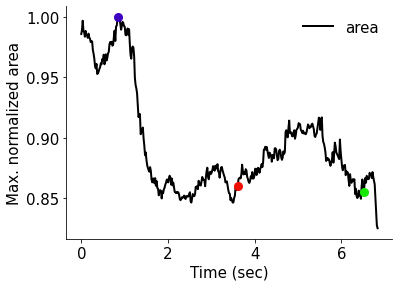

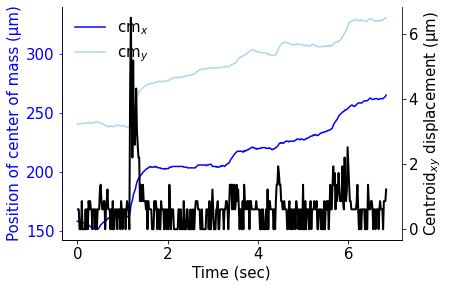

In [16]:
SAVE_FIGURES = False
plt.rcParams["font.size"] = 15

# Select sub_frames for highlighting
highlight_frames = [51, 216, 390]  # only considers the frames shown as subsample
cmcolors = [colors[hl] for hl in highlight_frames]

# Figures Rotifer body shape outline area
plt.figure(figsize=(5.8,4.25))
plt.plot(df["time"], df["area"] / df["area"].max(), "-k", lw=2, label="area")
for cframe, cm_hl in zip(highlight_frames, cmcolors):
    plt.plot(df.loc[cframe, "time"], df.loc[cframe, "area"] / df["area"].max(), "o", color=cm_hl, ms=8)

plt.xlabel("Time (sec)"); plt.ylabel("Max. normalized area");
plt.legend(frameon=False)
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-area.jpg", dpi=300)

# Figure Double YAxis Rotifer center of mass and displacement
plt.figure(figsize=(6.5,4.25))
ax1 = plt.gca()
ax1.plot(df["time"], df["centroid_x"] * pixel_per_real_width, "-", color="blue", lw=1.5, label="cm$_x$")
ax1.plot(df["time"], df["centroid_y"] * pixel_per_real_width, "-", color="lightblue", lw=1.5, label="cm$_y$")
ax1.set_ylabel("Position of center of mass (µm)"); ax1.set_xlabel("Time (sec)"); 
ax1.spines["left"].set_color("blue")
ax1.yaxis.label.set_color("blue")
ax1.tick_params(axis="y", color="blue")
ax1.set_yticklabels(labels=[int(x) for x in ax1.get_yticks()], color="blue")

ax2 = plt.twinx()
ax2.plot(df["time"], df["centroid_dist"] * pixel_per_real_width, "-k", lw=2)
ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color("black")

ax2.set_xlabel("Time (sec)"); ax2.set_ylabel("Centroid$_x$$_y$ displacement (µm)");
ax1.legend(frameon=False)
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-centroids.jpg", dpi=300)

## Plot raw images and overlay mask contour

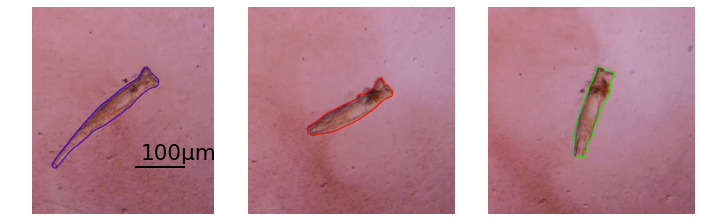

In [28]:
SAVE_FIGURES = False

desired_scale_width = 100  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)
contour_lw = 2  # contor line width

fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=len(highlight_frames), layout="constrained")
longest = 700 # 800 pixels is longest extension
# ± extention > make it more felxible with different xneg, xpos, yneg, ypos values
scalebar_posxy = [350, 200]
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for nth, cframe in enumerate(highlight_frames):
    
    # Centering frame on Centroid
    x, y = df.loc[cframe, "centroid_x"], df.loc[cframe, "centroid_y"]
    xlow, xhigh = x - (longest / 2), x + (longest / 2)
    ylow, yhigh = y - (longest / 2), y + (longest / 2)
    
    # Image and contour coloring
    cimg = cv2.imread(df.loc[cframe, "img_fpath"], 1)
    #cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)
    #cimg = clahe.apply(cimg)
    #cimg = cv2.cvtColor(cimg, cv2.COLOR_GRAY2RGB)
    cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)  # original color
    cnt = contour_list[cframe]  # contour
    ccolors = tuple([c * 255 for c in colors[cframe]])
    
    # Draw contour on image
    cv2.drawContours(cimg, [cnt], 0, ccolors, contour_lw)
    ax[nth].imshow(cimg)

    # Axis
    ax[nth].invert_yaxis()
    ax[nth].set_ylim([ylow, yhigh]); ax[nth].set_xlim([xlow, xhigh])
    ax[nth].set_axis_off()

# Scalebar
ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
ax[0].text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width}µm", size="x-large")
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-Individual-frames-highlighted_{highlight_frames}.jpg", dpi=300)

## Segmentation Mask plots over time

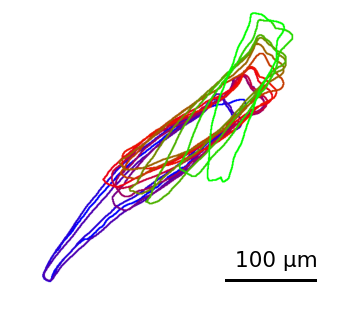

In [18]:
SAVE_FIGURES = False # Scale bar > can be moved somewhere else or config for defaults

scalebar_posxy = [400, 200]  # automate or set axis tight and then have a 0-100 scale with corresponding ticks
cxlim = [0, 600]
cylim = [150, 700]

# Prep subsampled data
sub_maskpaths = df["mask_fpath"].tolist()[::every_nth_frame]
#sub_imgpaths = df["img_fpath"].tolist()[::every_nth_frame]
sub_contours = contour_list[::every_nth_frame]

# Background white
first_frame = cv2.imread(sub_maskpaths[0])
background = np.ones_like(first_frame) * 255

# Get subsampled contours
for nth, cnt in enumerate(sub_contours):
    ccolors = sub_colors[nth]
    ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
    cv2.drawContours(background, [cnt], 0, (ccolors[0], ccolors[1], ccolors[2]), 2)

# Figure - Draw contours
plt.figure(figsize=(5,5), layout="constrained")
plt.imshow(background)
plt.xlim(cxlim); plt.ylim(cylim);
plt.axis("off")

# Scalebar
plt.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
plt.text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width} µm", size="x-large")
plt.tight_layout() # can also set limits in next cell or give back the ax handle?!

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-fps_{fps}-subsampled_{every_nth_frame}.jpg", dpi=300)

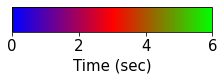

In [19]:
import matplotlib as mpl
fig = plt.figure(figsize=(3, 1), layout='constrained')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=int(df["time"].max())), cmap=mpl.cm.brg),
             cax=fig.gca(), orientation='horizontal', label='Time (sec)')
if SAVE_FIGURES: fig.savefig(f"{save_figure_path}-colorbar.jpg", dpi=300)

## Fit ellipse and orient anterior-posterior

120.9927749633789


(300.0, 800.0)

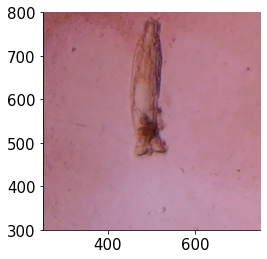

In [36]:
cframe = 216#51

# img
cimg = cv2.cvtColor(cv2.imread(df.loc[cframe, "img_fpath"], 1), cv2.COLOR_BGR2RGB)
h, w = cimg.shape[:2]
center = (w/2, h/2)

# mask
cmask = cv2.imread(df.loc[cframe, "mask_fpath"], 0)

angle = df.loc[cframe, "orientation"]
print(angle)
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
cimg_rot = cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h))


plt.imshow(cimg)
plt.imshow(cmask)
plt.imshow(cimg_rot)
plt.xlim(250,750);plt.ylim(300,800);

In [108]:
import skimage.morphology as morph

rot_imgs = []
rot_masks = []
rot_thin = []

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotate
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    #center = (row["centroid_x"], row["centroid_y"])
    angle = row["orientation"]  # fitted ellipse angle
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask, thin
    rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))
    
    if  nth % every_nth_frame == 0:
        # Thinning / skeletonize
        cthin = morph.thin(cmask).astype("uint8")
        #print(nth, cimg.dtype, cmask.dtype, cthin.dtype)
        rot_thin.append(cv2.warpAffine(src=cthin, M=rotate_matrix, dsize=(w, h)))


0 uint8 uint8 uint8
30 uint8 uint8 uint8
60 uint8 uint8 uint8
90 uint8 uint8 uint8
120 uint8 uint8 uint8
150 uint8 uint8 uint8
180 uint8 uint8 uint8
210 uint8 uint8 uint8
240 uint8 uint8 uint8
270 uint8 uint8 uint8
300 uint8 uint8 uint8
330 uint8 uint8 uint8
360 uint8 uint8 uint8
390 uint8 uint8 uint8


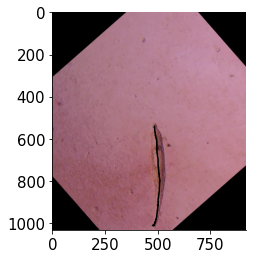

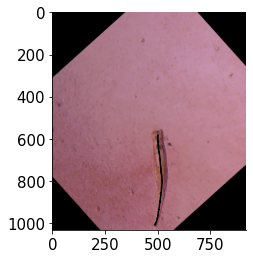

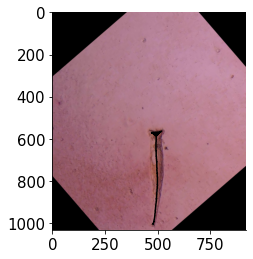

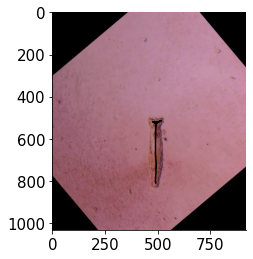

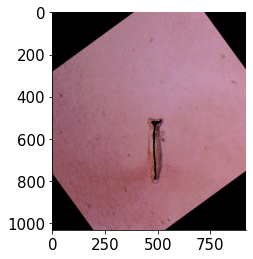

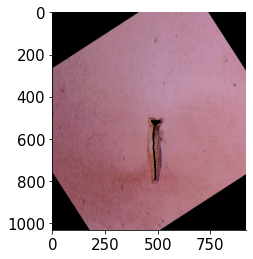

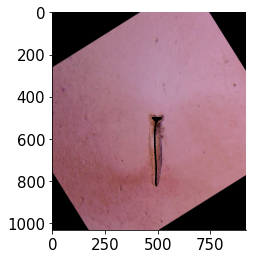

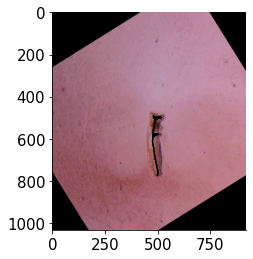

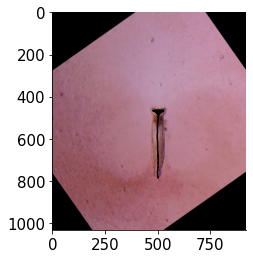

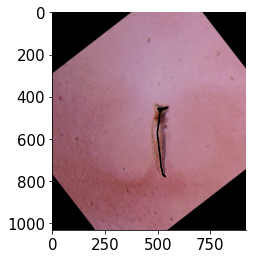

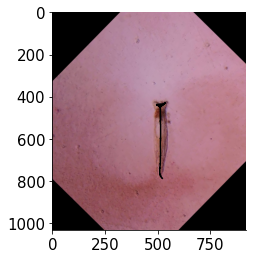

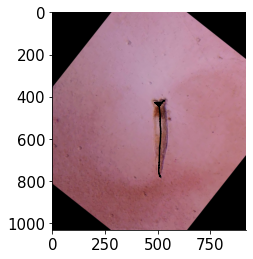

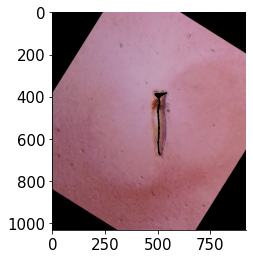

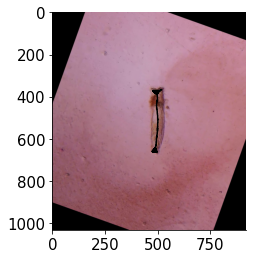

In [116]:
counter=0
for nth, row in df.iterrows():
    if  nth % every_nth_frame == 0:
        plt.figure()
        plt.imshow(rot_imgs[nth])
        y, x = np.where(rot_thin[counter] != 0)
        plt.plot(x,y, "-k")
        counter += 1

In [112]:
video = cv2.VideoWriter("rotate_test_video_center.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=60, frameSize=(w, h), isColor=True)

for frame in rot_imgs:
    video.write(frame)

cv2.destroyAllWindows()
video.release()


# Get rid of the take off > study differently! only mid-swimming 
- start by cutting that video again > using etl tools
- track again
- check skeletion then (morpho.medial_axis(img_as_bool)) can be tried...
- function to align to front (yaxis) and center (xaxis)
- take off clips and swimming clips from same rotifer > check the above graphs whether a measurement can be used to get them out quantitatively?!

[(-25.0, 25.0), (-20.0, 450.0)]

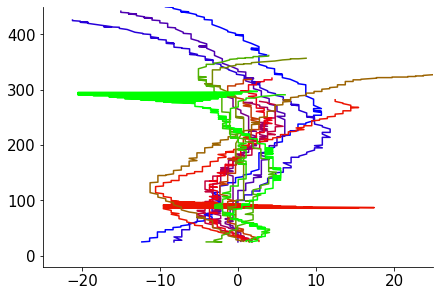

In [141]:
rot_thin[0]
fig, ax = plt.subplots(layout="constrained")
for nth, line in enumerate(rot_thin):
    y, x = np.where(line != 0)
    y = y - y.min()
    idx = y >= 25
    x = x[idx] - x[idx].mean()
    y = y[idx]
    ax.plot(x, y, "-", color=sub_colors[nth])
    #ax[0].invert_yaxis()

ax.set(xlim=(-25,25), ylim=(-20, 450))

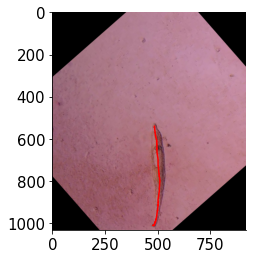

In [115]:
line = rot_thin[0]
y, x = np.where(line != 0)
plt.figure()
plt.imshow(rot_imgs[0])
plt.plot(x, y, "-r")